# Training Models(Gradient Descent、Regularization、Learning Curve and some Linear Models)

1. 使用稱為梯度下降 (GD) 的迭代優化方法，逐漸調整模型參數以最小化訓練集的cost function。 研究梯度下降的幾種變體：Batch GD、Mini-batch GD 和 Stochastic GD。

2. 使用learning curves來檢測是否overfitting

3. 看幾種regularization技術，可以降低過度擬合訓練集的風險: L1、L2、early stopping

4. Logistic 回歸和 Softmax 回歸

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


為了防止一些Sklearn更新的不必要警告:

In [2]:
# import warnings filter
from warnings import simplefilter
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

隨便創建一個數據集

In [3]:
np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

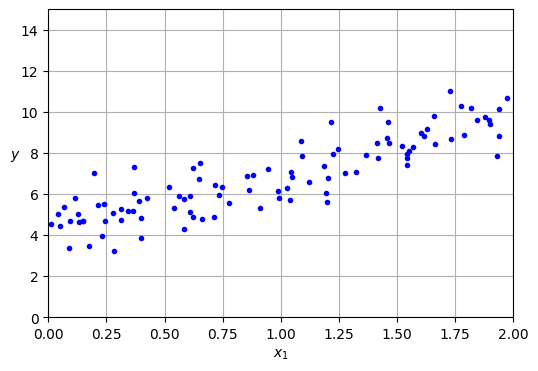

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

此線性方程式最好的參數theta_best

In [5]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

theta_best

array([[4.21509616],
       [2.77011339]])

y = 4.215 + 2.77x

In [6]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance

## Linear Regression

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## Gradient Descent

### Batch Gradient Descent

In [9]:
eta = 0.1  # learning rate
n_epochs = 1000 #iteration次數
m = len(X_b)  # number of instances

In [10]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters
theta

array([[ 0.49671415],
       [-0.1382643 ]])

In [11]:
for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

That’s exactly what the Normal Equation found! Gradient Descent worked perfectly. But what if you had used a different learning rate eta?

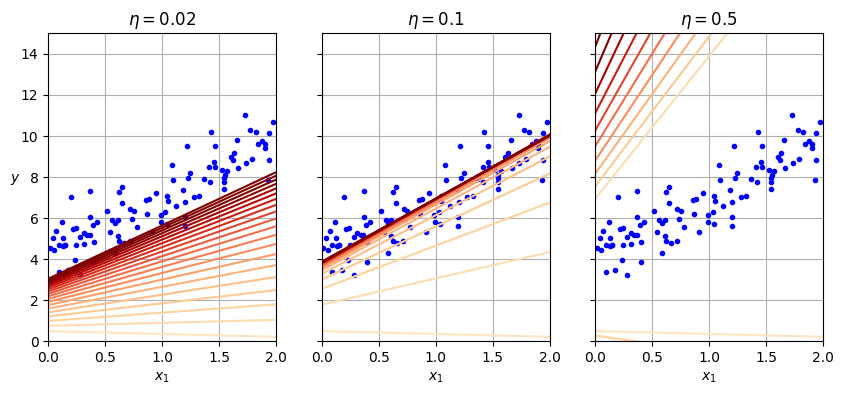

In [13]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()


左側，學習率太低，算法最終會到達解，但需要很長時間。 中間，學習率看起來非常好，在幾次迭代後，它已經收斂到解決方案。 在右邊，學習率太高，
算法發散，到處跳，實際上每一步都離解決方案越來越遠。

要找到一個好的學習率，可以使用網格搜索。 但是，可能希望限制迭代次數，以便消除收斂時間過長。

如何設置迭代次數? 如果它太低，當算法停止時你仍然離最優解很遠，但如果它太高，你會在模型參數不再變化時浪費時間。 一個簡單的解決方案是設置非常大的迭代次數，但在梯度向量變得很小時中斷算法，即當它的norm變得小於一個很小的數 ε（called the tolerance）時，因為這發生在梯度下降(幾乎)達到最低點。

### Stochastic Gradient Descent

In [14]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

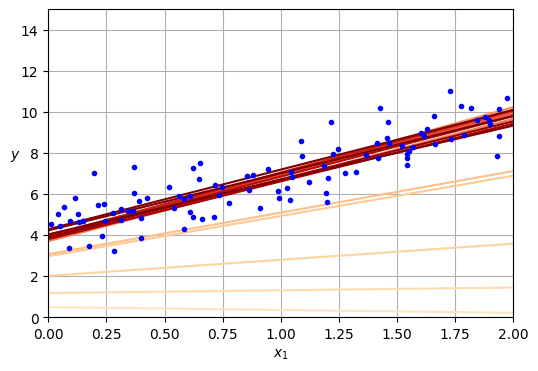

In [15]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

Batch Gradient Descent 代碼在整個訓練集中迭代了 1,000 次，但Stochastic Gradient Descent這段代碼僅通過訓練集 50 次就達到了相當不錯的參數

In [16]:
theta

array([[4.21076011],
       [2.74856079]])

使用Stochastic Gradient Descent時，訓練observation必須獨立同分佈 (IID)，以確保平均將參數拉向全局最優值。 確保這一點的一種簡單方法是在訓練期間打亂observation（例如，隨機選擇每個observation，或在每個時期開始時打亂訓練集）。 如果不這樣做，例如，如果實observation按標籤排序，則 SGD 將首先針對一個標籤進行優化，然後是下一個，依此類推，並且它不會接近全局最小值。

要通過 Scikit-Learn 使用 SGD 執行線性回歸，可以使用 SGDRegressor ，它默認MSE為cost function並優化(減少)MSE

In [17]:
sgd_reg = SGDRegressor(max_iter=1000, #iteration
                       tol=1e-5, #直到損失在一個時期內下降小於1e-5
                       penalty=None, #不使用任何正則化，設'l2'便是ridge回歸，'l1'是lasso 回歸
                       eta0=0.01, #starting with a learning rate of 0.1 
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Learning Curve

使用交叉驗證來估計模型的泛化性能。 如果一個模型在訓練數據上表現良好，但根據交叉驗證指標泛化不佳，那麼你的模型就過度擬合了。 如果它在這兩個方面都表現不佳，那麼它就是欠擬合的。 這是判斷模型何時太簡單或太複雜的一種方法。

另一種方法是查看Learning Curve，Scikit-Learn 有一個有用的 learning_curve() 函數來幫助解決這個問題：它使用交叉驗證來訓練和評估模型。 默認情況下，它會根據不斷增長的訓練集子集重新訓練模型，但如果模型支持增量學習，可以在調用 learning_curve() 時設置 exploit_incremental_learning = True，它會以增量方式訓練模型。

用一個簡單線性模型擬合數據

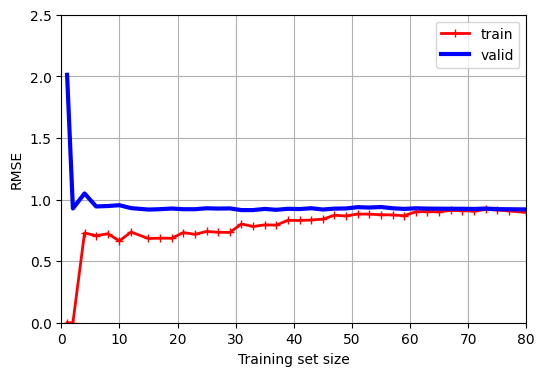

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40), # generate an array of 40 numbers evenly spaced between 0.01 and 1.0 
    cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])


plt.show()

首先，讓我們看一下在訓練數據上的表現：當訓練集中只有一兩個observation時，模型可以完美地擬合它們，這就是曲線從零開始的原因。 但是隨著新observation被添加到訓練集中，模型不可能完美地擬合訓練數據，這既是因為數據是noisy的，也是因為它根本不是線性的。 因此，訓練數據的誤差會上升，直到達到穩定狀態，此時向訓練集添加新實例不會使平均誤差好轉或惡化。 現在讓我們看看模型在驗證數據上的表現。 當模型在非常少的訓練observation上進行訓練時，它無法正確泛化，這就是驗證錯誤最初非常大的原因。 然後，隨著模型顯示更多的訓練示例，它會學習，因此驗證錯誤會慢慢下降。 然而，直線再一次不能很好地對數據建模，因此誤差最終處於平穩狀態，非常接近另一條曲線。 這樣的學習曲線是典型的欠擬合模型。 兩條曲線都達到了平穩狀態； 他們很近而且相當高。

用一個多次方模型擬合數據

In [19]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40), # generate an array of 40 numbers evenly spaced between 0.01 and 1.0 
    cv=5,
    scoring="neg_root_mean_squared_error")

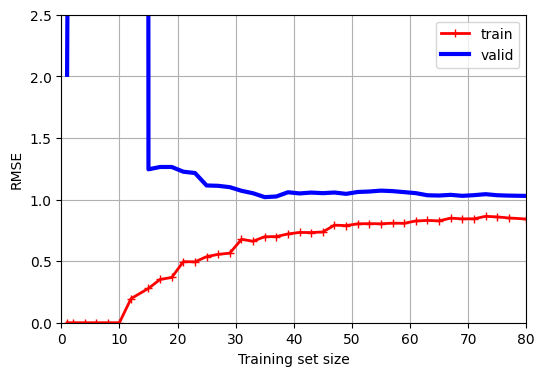

In [20]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

* 訓練數據的誤差遠低於簡單線性回歸模型。

* 曲線之間有間隙。 這意味著該模型在訓練數據上的表現明顯優於在驗證數據上的表現，這是過度擬合模型的標誌。 但是，如果您使用更大的訓練集，兩條曲線會繼續靠近。

## Regularized Linear Models

對於線性模型，正則化通常通過約束模型的權重來實現

### Ridge Regression

迫使學習算法不僅要適應數據，還要使模型權重盡可能小。 請注意，正則化項只能在訓練期間添加到cost function中。 訓練模型後，使用非正則化性能度量來評估模型的性能。

隨便生成一個數據集

In [21]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

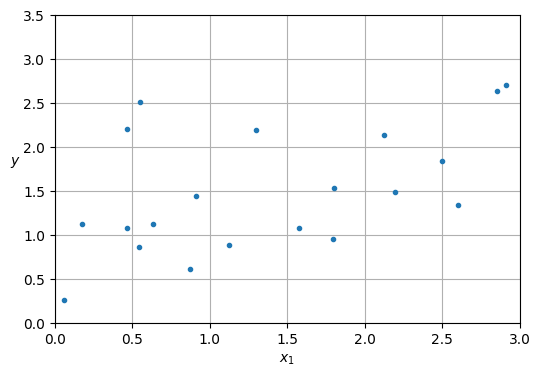

In [22]:
#  a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

方法一

In [23]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

In [24]:
ridge_reg.intercept_, ridge_reg.coef_

(array([0.97898394]), array([[0.3828496]]))

方法二

In [25]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])


array([1.55302613])

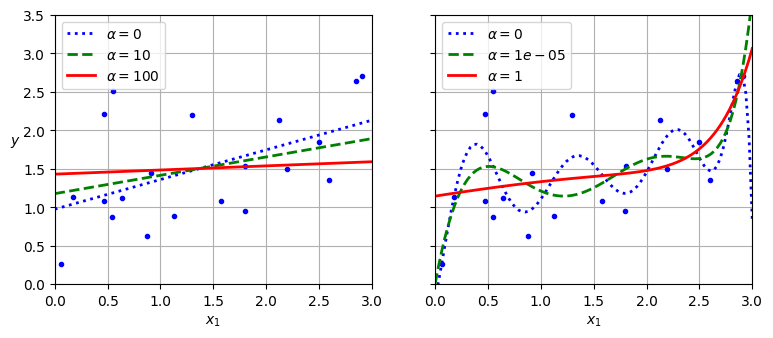

In [26]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

增加 α 導致更平坦（即不那麼極端，更合理）的預測； 這減少了模型的variance，但增加了它的bias。

### Lasso Regression

就像ridge回歸一樣，它在成本函數中添加了一個正則化項，但是是使用l1正則化(ridge是l2)

方法一

In [27]:

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [28]:
lasso_reg.intercept_, lasso_reg.coef_

(array([1.14537356]), array([0.26167212]))

方法二

In [29]:
lassoreg = SGDRegressor(penalty="l1", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
lasso_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
lasso_reg.predict([[1.5]])

array([1.53788174])

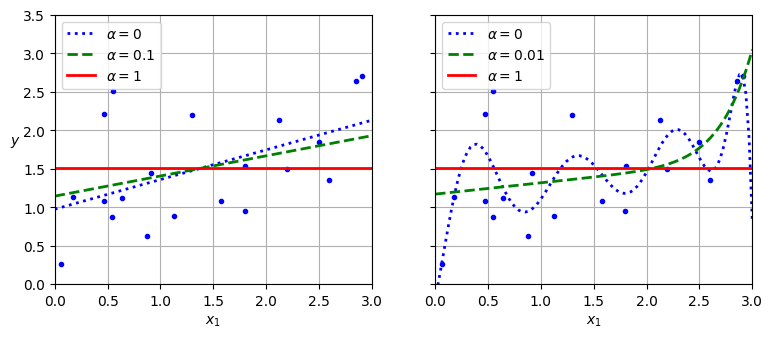

In [30]:
# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

### Elastic Net

Elastic Net 是 Ridge 回歸和 Lasso 回歸之間的中間地帶。 正則化項是 Ridge 和 Lasso 正則化項的簡單混合，您可以控制混合比 r。 當r = 0時，Elastic Net等於Ridge Regression，當r = 1時，等於Lasso Regression。

In [31]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

一種正則化迭代學習算法防指過度擬合（例如正則化梯度下降）的方法是在驗證誤差達到最小值時立即停止訓練。隨著 epoch 的流逝，算法不斷學習，其在訓練集上的預測誤差 (RMSE) 自然會下降，在驗證集上的預測誤差也會下降。 然而，一段時間後，驗證錯誤停止減少，實際上開始回升。 這表明模型已經開始過度擬合訓練數據。使用Early Stopping，只需在驗證錯誤達到最小值時立即停止訓練。 這是一種簡單而有效的正則化技術，Geoffrey Hinton 稱其為“beautiful free lunch”。

隨便生成一個數據集

In [32]:
# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

以下代碼 : 在預處理後創建沒有正則化和小學習率的 SDGRegressor 模型。 在訓練循環中，它調用 partial_fit() 而不是 fit() 來執行增量學習。 在每個時期，它都會測量驗證集上的 RMSE。 如果它低於目前看到的最低 RMSE，它會保存模型的副本。 此實現實際上並沒有停止訓練，但它可以讓您在訓練後恢復到最佳模型(以防驗證集錯誤停止減少反而開始回升的狀況發生而錯過最佳模型)。 請注意，模型是使用 copy.deepcopY() 複製的，因為它同時復制了模型的超參數和學習參數。 相反，sklearn.base.clone() 只複製模型的超參數。

In [33]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

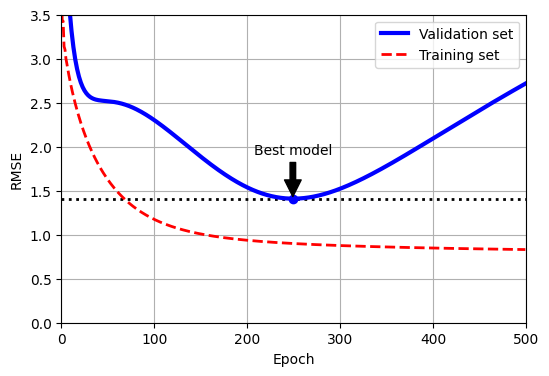

In [34]:

# extra code – this section generates Figure 
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

## Logistic Regression

來做一個邏輯思回歸判斷花的品種是否為virginica

In [35]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [36]:
data = iris.data

In [37]:
y = iris.target_names[iris.target] == 'virginica'

y = pd.DataFrame({'virginica': y})

In [38]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, y):
    X_train = data.loc[train_index]
    X_test = data.loc[test_index] 
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

In [39]:
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
33,5.5,4.2,1.4,0.2
106,4.9,2.5,4.5,1.7
54,6.5,2.8,4.6,1.5
55,5.7,2.8,4.5,1.3
19,5.1,3.8,1.5,0.3


In [40]:
y_train.head()

,virginica
33,False
106,True
54,False
55,False
19,False


In [41]:
full_pipeline = Pipeline([
    ("logistic", LogisticRegression(random_state=42)),
])

Scikit-Learn 中控制 LogisticRegression 模型正則化強度的超參數不是 alpha（與其他線性模型一樣），而是它的倒數 C。C 值越高，模型正則化程度越低。這邊只是隨便設看看

In [42]:
param_grid = [{'logistic__C' : [1.0,2.0,3.0,5.0,10.0, 20.0, 40.0]}]

In [43]:
grid_search = GridSearchCV(
    full_pipeline, param_grid, cv = StratifiedKFold(n_splits=5), scoring="accuracy", error_score="raise"
)

In [44]:
y_train = y_train["virginica"].values

In [45]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('logistic',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'logistic__C': [1.0, 2.0, 3.0, 5.0, 10.0, 20.0,
                                          40.0]}],
             scoring='accuracy')

In [46]:
grid_search.best_params_

{'logistic__C': 1.0}

In [47]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_logistic__C", "split0_test_score","split1_test_score", "split2_test_score", "split3_test_score", "split4_test_score","mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "split3_cv", "split4_cv","mean_test_accuracy"]
cv_res.columns = ["C"] + score_cols

cv_res

,C,split0_cv,split1_cv,split2_cv,split3_cv,split4_cv,mean_test_accuracy
0,1.0,0.916667,1.0,1.0,0.916667,1.000000,0.966667
1,2.0,0.916667,1.0,1.0,0.916667,1.000000,0.966667
2,3.0,0.916667,1.0,1.0,0.916667,1.000000,0.966667
3,5.0,0.916667,1.0,1.0,0.916667,1.000000,0.966667
4,10.0,0.875000,1.0,1.0,0.916667,1.000000,0.958333
5,20.0,0.875000,1.0,1.0,0.916667,0.958333,0.950000
6,40.0,0.875000,1.0,1.0,0.916667,0.958333,0.950000


In [48]:
logistic_best = grid_search.best_estimator_
predictions = logistic_best.predict(X_test)

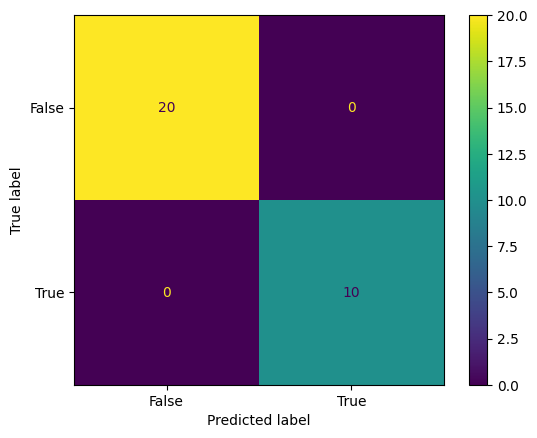

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

In [50]:
accuracy_score(y_test, predictions)

1.0

In [51]:
logistic_best.named_steps['logistic'].intercept_

array([-13.51057132])

In [52]:
coef_array = logistic_best.named_steps['logistic'].coef_
logistic_coef = pd.DataFrame(coef_array, columns=["sepal length (cm)_coef", "sepal width (cm)_coef",
                                       "petal length (cm)_coef", "petal width (cm)_coef"])
logistic_coef 

,sepal length (cm)_coef,sepal width (cm)_coef,petal length (cm)_coef,petal width (cm)_coef
0,-0.263798,-0.476483,2.656594,2.119648


* sepal length (cm)：sepal length (cm)每增加一個單位，花是“virginic”的log-odds就會減少約0.263798個單位。

* sepal width (cm) : sepal width (cm)每增加一個單位，花是“virgini”的log-odds就會減少約0.476483個單位。

* petal length (cm): petal length (cm)每增加一個單位，花是“virgini”的log-odds就會增加約2.656594個單位。

* petal width (cm): petal width (cm)每增加一個單位，花是“virgini”的log-odds就會增加約2.119648個單位。

因為係數是log-odds，看勝算的話要做指數變換，舉例來說將變數Petal length (cm)的係數做exp transform

In [53]:
np.exp(2.65659369)

14.247674351613606

解讀範例 : Petal length (cm)每增加1公分，花是virginica類的勝算提高14.24767倍

### softmax Regression(miltinomial logistic regression)

Logistic 回歸模型可以泛化為直接支持多個類別，而無需訓練和組合多個二元分類器。 這稱為 Somax 回歸，或多項式 Logistic 回歸。 這個想法很簡單：當給定一個實例 x 時，Softmax 回歸模型首先為每個類別 k 計算一個分數 sk(x)，然後通過應用 somax 函數（也稱為歸一化指數）估計每個類別的概率。(Softmax 回歸分類器一次只預測一個類（即它是多類，而不是多輸出），因此它應該只用於相互排斥的類，例如不同類型的植物。 你不能用它來識別一張照片中的多個人。)

In [54]:
data = iris.data
y = iris["target"]

In [55]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, y):
    X_train = data.loc[train_index]
    X_test = data.loc[test_index] 
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

In [56]:
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=30, random_state=42)

In [60]:
predictions = softmax_reg.predict(X_test)

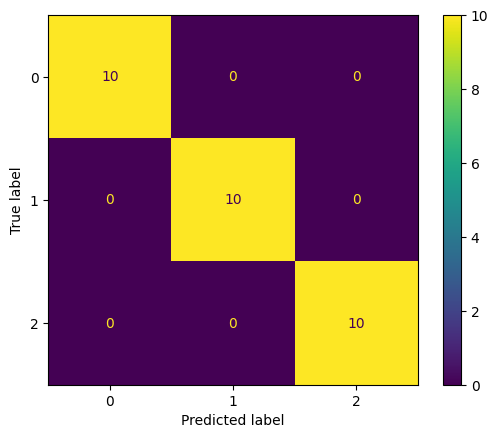

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)